In [14]:

import pandas as pd
from sklearn.cluster import Birch
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment

AttributeError: partially initialized module 'smart_open' has no attribute 'local_file' (most likely due to a circular import)

In [3]:
# Load the dataset
file_path = '../date/clean_data_filtered.csv'  # Update this path as needed
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...
1,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...
2,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...
3,1908,The Black Viper,American,D. W. Griffith,D. W. Griffith,drama,https://en.wikipedia.org/wiki/The_Black_Viper,A thug accosts a girl as she leaves her workpl...
4,1908,A Calamitous Elopement,American,D.W. Griffith,"Harry Solter, Linda Arvidson",comedy,https://en.wikipedia.org/wiki/A_Calamitous_Elo...,A young couple decides to elope after being ca...


In [4]:
row_count = data.shape[0]
print(row_count)

15136


In [5]:

# Preprocessing
# Drop irrelevant columns
data = data.drop(columns=['Wiki Page', 'Title', 'Director', 'Cast'])

# Encode categorical variables
label_encoder = LabelEncoder()
data['Origin/Ethnicity'] = label_encoder.fit_transform(data['Origin/Ethnicity'])
data['Genre'] = label_encoder.fit_transform(data['Genre'])

In [6]:
# Tokenize the 'Plot' column
tokenized_plots = data['Plot'].fillna('').apply(lambda x: x.split())

In [7]:

# Train Word2Vec model on the tokenized plots
word2vec_model = Word2Vec(sentences=tokenized_plots, vector_size=100, window=5, min_count=1, workers=4)


In [8]:
# Generate embeddings for each plot by averaging word embeddings
def get_plot_embedding(plot):
    embeddings = [word2vec_model.wv[word] for word in plot if word in word2vec_model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)


In [9]:
plot_embeddings = tokenized_plots.apply(get_plot_embedding)
plot_embeddings = np.vstack(plot_embeddings.values)

In [10]:
# Combine numeric and textual features
numeric_features = data[['Release Year', 'Origin/Ethnicity', 'Genre']].values
numeric_features = StandardScaler().fit_transform(numeric_features)  # Standardize numerical features

In [11]:
# Combine numeric features and plot embeddings
combined_features = np.hstack((numeric_features, plot_embeddings))

In [12]:
# Apply RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
combined_features_oversampled, labels_oversampled = oversampler.fit_resample(combined_features, data['Genre'])


In [13]:
# Apply Birch Clustering on the oversampled data
birch_model = Birch(n_clusters=5, threshold=0.2, branching_factor=30)
birch_model.fit(combined_features_oversampled)

# Get the cluster labels for the oversampled data
oversampled_cluster_labels = birch_model.labels_

# Map the oversampled cluster labels back to the original data
# Since oversampling creates additional rows, you need to align the oversampled labels
data['cluster'] = oversampled_cluster_labels[:len(data)]

In [14]:
# Mapping cluster labels to true labels
def map_labels(true_labels, cluster_labels):
    contingency_matrix = pd.crosstab(true_labels, cluster_labels)
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix.values)  # Hungarian algorithm
    mapping = {col: row_ind[i] for i, col in enumerate(col_ind)}
    default_label = max(row_ind) + 1  # Default label for unmapped clusters
    return [mapping.get(label, default_label) for label in cluster_labels]

# Map cluster labels to match true labels
mapped_labels = map_labels(data['Genre'], data['cluster'])

# Calculate accuracy
cluster_accuracy = accuracy_score(data['Genre'], mapped_labels)
print(f'Cluster Accuracy: {cluster_accuracy}')
# For evaluation metrics, use Silhouette Score
silhouette_avg = silhouette_score(
    combined_features_oversampled, birch_model.labels_
)
print(f"Silhouette Score: {silhouette_avg}")
# Adjusted Rand Index
ari_score = adjusted_rand_score(labels_oversampled, birch_model.labels_)
print(f"Adjusted Rand Index (ARI): {ari_score}")

# Normalized Mutual Information (NMI)
nmi_score = normalized_mutual_info_score(labels_oversampled, birch_model.labels_)
print(f"Normalized Mutual Information (NMI): {nmi_score}")


Cluster Accuracy: 0.45130813953488375


In [15]:
# For evaluation metrics, use Silhouette Score
silhouette_avg = silhouette_score(
    combined_features_oversampled, birch_model.labels_
)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.16240132237892185


In [16]:
# Adjusted Rand Index
ari_score = adjusted_rand_score(labels_oversampled, birch_model.labels_)
print(f"Adjusted Rand Index (ARI): {ari_score}")

# Normalized Mutual Information (NMI)
nmi_score = normalized_mutual_info_score(labels_oversampled, birch_model.labels_)
print(f"Normalized Mutual Information (NMI): {nmi_score}")


Adjusted Rand Index (ARI): 0.29736106452532557
Normalized Mutual Information (NMI): 0.4094525638790598


In [17]:
# Apply PCA to reduce the combined features to 2D and 3D for visualization
pca_2d = PCA(n_components=2)
reduced_2d = pca_2d.fit_transform(combined_features)

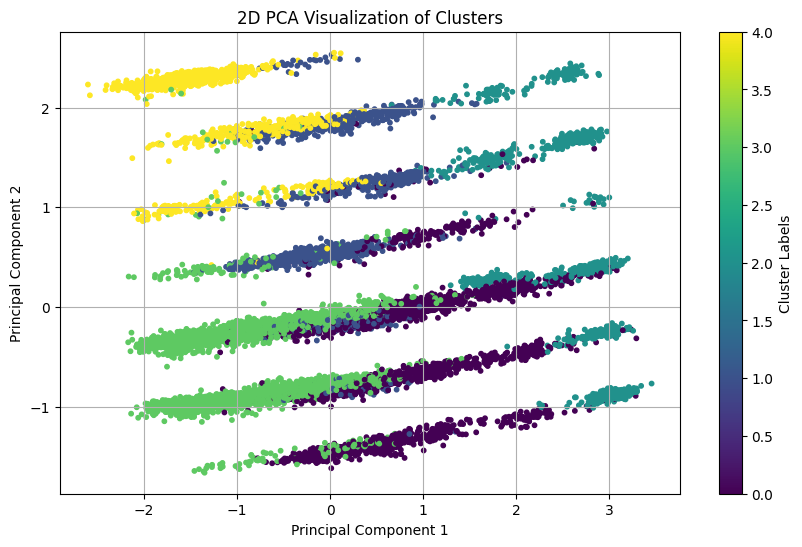

In [18]:
# 2D scatter plot of the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_2d[:, 0], reduced_2d[:, 1], c=data['cluster'], cmap='viridis', s=10)
plt.colorbar(scatter, label="Cluster Labels")
plt.title("2D PCA Visualization of Clusters with ONLY Word2Vec Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()